<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_2_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [ ]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

Training on cpu
Flower 1.12.0 / PyTorch 2.5.0+cu121


In [ ]:
!pip install matplotlib

# Dataloader


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 10
BATCH_SIZE = 32

def load_datasets(partition_id: int, num_partitions: int):
    # Initialize the FederatedDataset with partitioning scheme
    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": IidPartitioner(num_partitions=num_partitions)}
    )

    # Define transforms
    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    # Load and partition the dataset
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    # Create DataLoaders
    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    # Load the test set split (not partitioned)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader


Histogram of the dataset


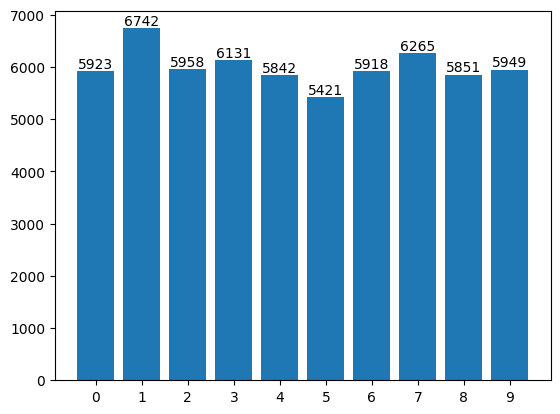

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset

# Download dataset
mnist = load_dataset("ylecun/mnist")

# construct histogram
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()])

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


# train test Func


In [ ]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for batch in trainloader:
        images, labels = batch["image"], batch["label"]
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()


def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"], batch["label"]
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

# centralised

In [ ]:
def run_centralised(
    trainloader,
    testloader,
    epochs: int,
    lr: float,
    momentum: float = 0.9
):

    # instantiate the model
    model = Net(num_classes=10)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train for the specified number of epochs
    for e in range(epochs):
        print(f"Training epoch {e} ...")
        train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

In [ ]:
# Construct dataloaders
trainloader, _, testloader = load_datasets(partition_id=0, num_partitions=1)

# Run the centralised training
run_centralised(trainloader, testloader, epochs=5, lr=0.01)

Training epoch 0 ...
Training epoch 1 ...
Training epoch 2 ...
Training epoch 3 ...
Training epoch 4 ...
loss = 12.655296282486233
accuracy = 0.9873


# Clients partitions


In [ ]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 100

partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)

fds = FederatedDataset(dataset="ylecun/mnist", partitioners={"train": partitioner})

## homogenus distribution

In [ ]:
from flwr_datasets.visualization import plot_label_distributions

partition_0 = fds.load_partition(0)

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

# Flwr client


## set-get params


In [ ]:
# Two auxhiliary functions to set and extract parameters of a model
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # now replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

In [ ]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, partition_id, trainloader, valloader, model):
        super().__init__()
        self.partition_id = partition_id
        self.trainloader = trainloader
        self.valloader = valloader
        self.model = model

    def get_parameters(self, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

      #  Return the current local model parameters
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Receive parameters sent by the server into client's local model
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_params(self.model, parameters)

        # # Define the optimizer
        # optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # local training
        train(self.model, self.trainloader, optim, epochs=1)
        # return the model parameters to the server as well as extra info
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_params(self.model, parameters)
        # do local evaluation
        loss, accuracy = test(self.model, self.valloader)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

    def fit_config(server_round: int):
        """Return training configuration dict for each round.

        Perform two rounds of training with one local epoch, increase to two local
        epochs afterwards.
        """
        config = {
            "server_round": server_round,  # The current round of federated learning
            "local_epochs": 1 if server_round < 2 else 2,
        }
        return config


## client func

In [ ]:
from flwr.common import Context
from flwr.client import ClientApp


def client_fn(context: Context) -> Client:
    """Returns a FlowerClient containing its data partition."""
    # Load model
    model = Net(num_classes=10).to(DEVICE)

    partition_id = int(context.node_config["partition-id"])

    ###################################################################################
    # the client loads a full data partition
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)
    # PARTITION DATA  each client gets a different trainloader/valloader to each client
    trainloader, testloader = get_mnist_dataloaders(partition_train_val, batch_size=32)
    ######################################################################################

    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    return FlowerClient(partition_id, model, trainloader, testloader).to_client()


In [ ]:
def client_fn(context: Context) -> Client:

    model = Net(num_classes=10).to(DEVICE)

    # assigns the partition_id, num_partitions to each client
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    #  pre-splited
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    return FlowerClient(partition_id, net, trainloader, valloader).to_client()

In [ ]:
# Concstruct the ClientApp
client_app = ClientApp(client_fn=client_fn)

## Aggregation func


In [ ]:
from typing import List
from flwr.common import Metrics


# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

## Strategies



In [ ]:
strategy_1 = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    # initial_parameters, # initialised global model
)

In [ ]:
strategy_2 = FedAvgCustom(
        file_name="results_fedavgcustom",
        num_rounds=num_rounds,
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.25,  # 25% clients sample each round to do evaluate()
        # min_fit_clients=10,
        # min_evaluate_clients=5,
        # min_available_clients=10, # Wait until all 10 clients are available
        evaluate_metrics_aggregation_fn=weighted_average,  # weighted average

        initial_parameters=global_model_init,  # initialised global model

        evaluate_fn=get_evaluate_fn(testloader),  # gloabl evaluation (here we can pass the same testset as used in centralised)
    )

In [ ]:
strategy_3 = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
    )

### Fed Avg Custom

In [ ]:
from flwr.server.strategy import FedAvg
from flwr.common import Parameters
import json


class FedAvgCustom(FedAvg):
    def __init__(self, file_name: str, num_rounds: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_name = file_name
        self.num_rounds = num_rounds
        self.loss_list = []
        self.metrics_list = []

    def _make_plot(self):
        """Makes a plot with the results recorded"""
        round = list(range(1, len(self.loss_list) + 1))
        acc = [100.0 * metrics["accuracy"] for metrics in self.metrics_list]
        plt.plot(round, acc)
        plt.grid()
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Round")

    def evaluate(self, server_round: int, parameters: Parameters):
        """Evaluate model parameters using an evaluation function."""
        loss, metrics = super().evaluate(server_round, parameters)
        # Record results
        self.loss_list.append(loss)
        self.metrics_list.append(metrics)
        # If last round, save results and make a plot
        if server_round == self.num_rounds:
            # Save to CSV
            with open(f"{self.file_name}.json", "w") as f:
                json.dump({"loss": self.loss_list, "metrics": self.metrics_list}, f)
            # Generate plot
            self._make_plot()


def get_evaluate_fn(testloader):
    """Return a function that can be called to do global evaluation."""

    def evaluate_fn(server_round: int, parameters, config):
        """Evaluate global model on the whole test set."""

        model = Net(num_classes=10)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test (evaluate model as in centralised setting)
        loss, accuracy = test(model, testloader)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

# Server side


In [ ]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.server import ServerApp, ServerConfig


def server_fn(context: Context):

    # instantiate the model
    model = Net(num_classes=10)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy

    # Construct ServerConfig
    config = ServerConfig()

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy_1, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

# Run


In [ ]:
# each client will be allocated 2x CPU and 0x GPUs
backend_config = {"client_resources": None}

# each client will be allocated 1x CPU and 0x GPUs
# backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}


In [ ]:
from flwr.simulation import run_simulation

num_rounds = 5

run_simulation(
    server_app=server_app,
    num_rounds=num_rounds,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,# each group train locally and send their updates to the supernode for aggregation
    backend_config=backend_config,
)



---


# Server-side parameter evaluation

## Evaluate func on server

In [ ]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

## Strat

In [ ]:
strategy = FedAvg(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,  # Pass the evaluation function
    )

## Server func

In [ ]:
def server_fn(context: Context):
    # Define the strategy

    # Construct ServerConfig (num_rounds defined in the run funcion)
    config = ServerConfig()

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

## Run

In [ ]:
from flwr.simulation import run_simulation

num_rounds = 5

run_simulation(
    server_app=server,
    num_rounds=num_rounds,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,# each group train locally and send their updates to the supernode for aggregation
    backend_config=backend_config,
)